# Initializing an InfluxDB Client

Setting up basic parameter for influxDB client. 

In [2]:
from influxdb_client import InfluxDBClient
import warnings

# Initialize the InfluxDB client
token = "fP-GBq8Z1wZE7iW8qFBuxVy-ArVP9TqVec0naJ77XLECiwSr82aRXqvo3ylXZqU_2ad2vxWGcMoMbl3PXqAZ7A=="
server_url = "http://140.112.12.62:8086"
client = InfluxDBClient(url=server_url, token=token)
org = "NTUCE"
query_api = client.query_api()

# Disable influxdb pivot warning
import warnings
from influxdb_client.client.warnings import MissingPivotFunction
warnings.simplefilter("ignore", MissingPivotFunction)

## Query tipped time from TBRG.
The tipping bucket stores the closure time.  
Here we query the closure time and convert it into intensity.  
The intensity can be visualized using a bar chart or by averaging the depth between closures.

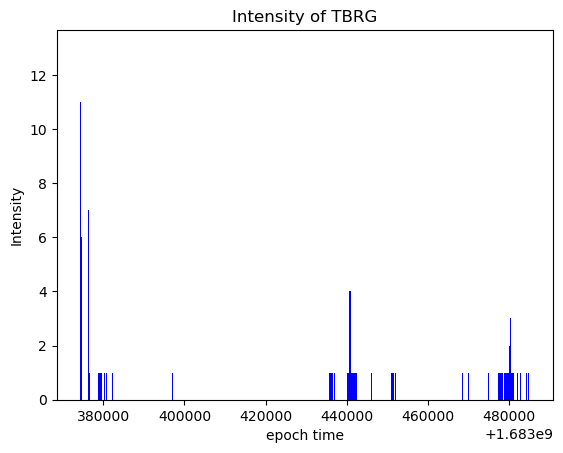

In [65]:
import matplotlib.pyplot as plt
import numpy as np

with open("flux/TBRG_closure.flux", "r") as fluxfile:
    query_str = fluxfile.read()
    closure = query_api.query_data_frame(org="NTUCE", query = query_str)
    # Drop useless columns
    closure.drop(columns=["result", "table"], inplace=True)

closure['min'] = closure['_time'].dt.floor('min')
grouped = closure.groupby('min')['_time'].count().reset_index(name='count')
grouped['min'] = grouped['min'].astype('int64')/1000000000

plt.bar(grouped['min'], grouped['count'], color='blue', width=200)
plt.title('Intensity of TBRG')
plt.xlabel('epoch time')
plt.ylabel('Intensity')
plt.show()


### Other way to calculate intensity
Here we create a function that can average the depth of single drop to the time window between last drop.  
In this way, We can see the intensity better than counting drop in each minutes.

In [45]:
def tip_to_intensity(tip_time: np.ndarray, depth: float) -> np.ndarray:
    # Calculate pre-allocate size we need
    sizeof_intensity_array = tip_time[-1]//60 - tip_time[0]//60 + 1 + 9 # last tip minute - first tip minute + 1(include head and tail) + 9(10 min before 1st tip(include))
    
    # Pre-allocate array (for performance)
    intensity_v= np.zeros(sizeof_intensity_array, dtype=np.float64)
    intensity_t = np.arange((tip_time[0]//60 - 9)*60, (tip_time[-1]//60 + 1)*60, 60, dtype=np.int64)
    intensity = np.array([intensity_t, intensity_v]).T

    # Offset for index of intensity array
    offset = tip_time[0]//60 - 9
    prev_tip = 0

    for tip in tip_time:
        if tip//60 == prev_tip//60:
            ### Accumulate intensity to each minute directly
            intensity[tip//60 - offset, 1] += depth
            continue

        prev_i = prev_tip//60 - offset
        tip_i = tip//60 - offset

        if tip//60 - prev_tip//60 > 10:
            ### Distribute intensity to each minute
            intensity[tip_i - 9:tip_i + 1, 1] += depth/10 

        else:
            # Calculate intensity for this period
            period_intensity = depth*60/(tip - prev_tip)
   			
            ### Distribute intensity to each minute

            # Head of intensity period
            intensity[prev_i, 1] += period_intensity*(60 - prev_tip%60)/60 

            # Body of intensity period
            intensity[prev_i + 1:tip_i, 1] += period_intensity

            # Tail of intensity period
            intensity[tip_i, 1] += period_intensity*(tip%60)/60

        prev_tip = tip
            
    return intensity[intensity[:, 1] != 0]

### Compare two method.
Plot both method in one graph to see result.

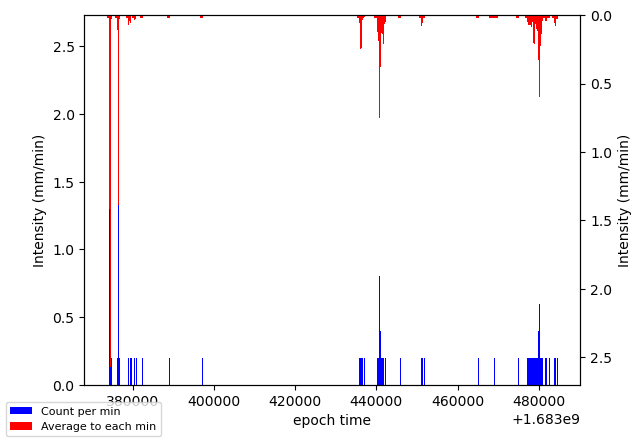

In [64]:
intensity_average = tip_to_intensity(np.array(closure['_time'].astype('int64')//10**9), 0.2)

fig, ax1 = plt.subplots()
plt.rcParams['legend.fontsize'] = 8

# Plot visibility
ax1.bar(grouped['min'], grouped['count']*0.2, color='blue', width=200, label="Count per min")
ax1.set_xlabel("epoch time")
ax1.set_ylabel("Intensity (mm/min)")

# Create a second y-axis
ax2 = ax1.twinx()

# Plot intensity
ax2.bar(intensity_average[:, 0], intensity_average[:, 1], color='red', width=200, label="Average to each min")
ax2.set_ylabel("Intensity (mm/min)")
ax2.invert_yaxis()

fig.legend(loc="lower left")
plt.show()